# Look into relationship between rides and weather data

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3
import numpy as np
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['lines.linewidth'] = 3

In [19]:
con1 = sqlite3.connect('data/citibike_database.db3')
con2 = sqlite3.connect('data/nyc_weather.db3')

In [20]:
year = 2014
rides = pd.read_sql_query("SELECT yday,count(*) as num_rides FROM rides WHERE year=? GROUP BY yday",con1,params=[year])
rides.head()

,yday,num_rides
0,1,6059
1,2,8600
2,3,1144
3,4,2292
4,5,2678


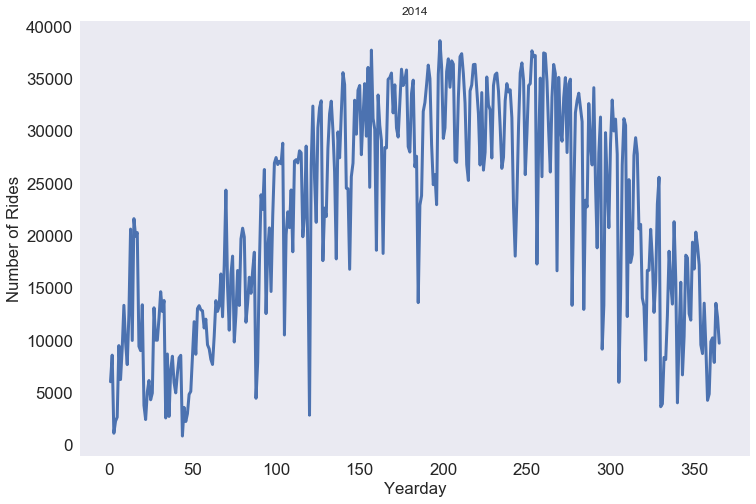

In [21]:
plt.figure(figsize=(12,8))
plt.plot(rides.yday, rides.num_rides)
plt.grid();
plt.xlabel('Yearday')
plt.ylabel('Number of Rides');
plt.title(str(year))

In [22]:
wea = pd.read_sql_query("SELECT * FROM temps WHERE year=?",con2,params=[year])
wea['date'] = pd.to_datetime(wea.date)
wea.loc[wea.precip_In=='T'] = 0
wea.loc[:,'precip_In'] = wea.astype({'precip_In':'float64'})
wea.set_index('date',inplace=True)
wea.head()


,st_code,max_temp,min_temp,mean_temp,year,yday,month,precip_In,cloud_cover,max_gust_mph,events
date,,,,,,,,,,,
2014-01-01,KLGA,33,25,29,2014,1,1,0.00,6,28,None
2014-01-02,KLGA,32,18,25,2014,2,1,0.18,8,36,Fog-Snow
2014-01-03,KLGA,19,10,15,2014,3,1,0.25,4,37,Fog-Snow
2014-01-04,KLGA,28,9,19,2014,4,1,0.00,2,21,None
2014-01-05,KLGA,50,25,38,2014,5,1,0.10,7,26,Fog-Rain


In [23]:
wea.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2014-01-01 to 2014-12-31
Data columns (total 11 columns):
st_code         365 non-null object
max_temp        365 non-null int64
min_temp        365 non-null int64
mean_temp       365 non-null int64
year            365 non-null int64
yday            365 non-null int64
month           365 non-null int64
precip_In       365 non-null float64
cloud_cover     365 non-null int64
max_gust_mph    365 non-null int64
events          171 non-null object
dtypes: float64(1), int64(8), object(2)
memory usage: 34.2+ KB


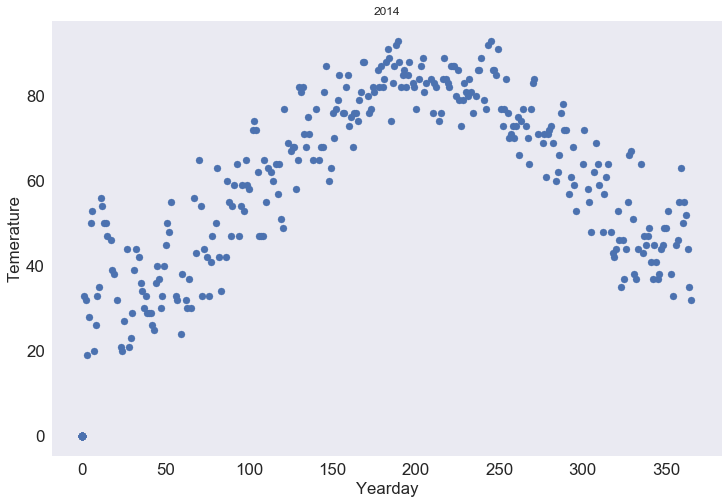

In [24]:
plt.figure(figsize=(12,8))
plt.scatter(wea.yday, wea.max_temp)
plt.grid();
plt.xlabel('Yearday')
plt.ylabel('Temerature');
plt.title(str(year))

Now join weather data to rides so we can plot # rides vs temperature for each day

In [25]:
comb = pd.merge(rides,wea,on='yday')
comb.head()

,yday,num_rides,st_code,max_temp,min_temp,mean_temp,year,month,precip_In,cloud_cover,max_gust_mph,events
0,1,6059,KLGA,33,25,29,2014,1,0.00,6,28,None
1,2,8600,KLGA,32,18,25,2014,1,0.18,8,36,Fog-Snow
2,3,1144,KLGA,19,10,15,2014,1,0.25,4,37,Fog-Snow
3,4,2292,KLGA,28,9,19,2014,1,0.00,2,21,None
4,5,2678,KLGA,50,25,38,2014,1,0.10,7,26,Fog-Rain


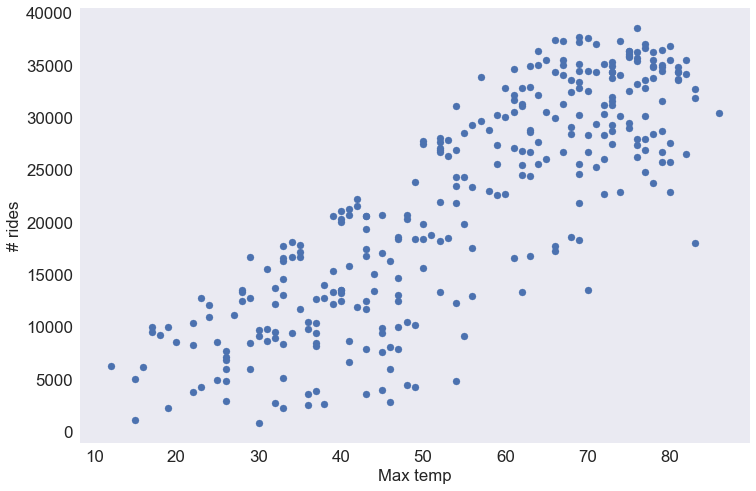

In [26]:
#plt.scatter(comb.Max_TemperatureF,comb.num_rides)
plt.figure(figsize=(12,8))
plt.scatter(comb.mean_temp,comb.num_rides)
plt.grid();
plt.xlabel('Max temp')
plt.ylabel('# rides')

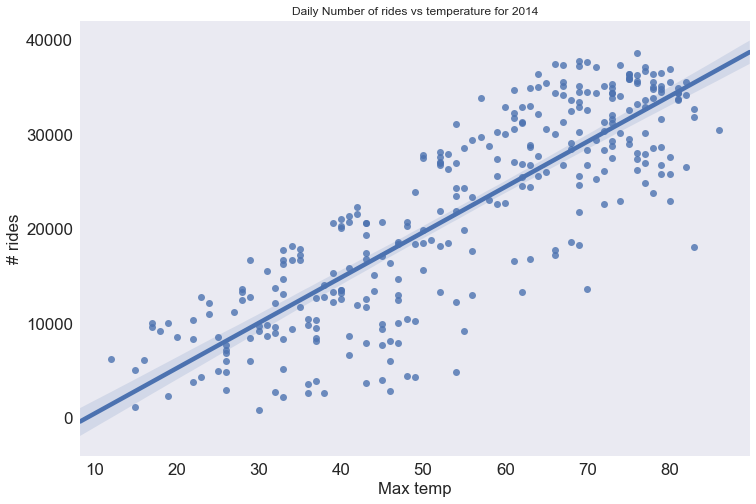

In [28]:
plt.figure(figsize=(12,8))
sns.regplot(comb.mean_temp,comb.num_rides)
plt.grid();
plt.xlabel('Max temp')
plt.ylabel('# rides')
plt.title('Daily Number of rides vs temperature for ' + str(year)) ;
plt.savefig('figures/rides_vs_temp_2015.pdf')

## Fit a linear regression using statsmodels

In [29]:
# Fit a linear regression
import statsmodels.formula.api as smf
# create a fitted model in one line
lm = smf.ols(formula='num_rides ~mean_temp', data=comb).fit()
# print the coefficients
lm.params

Intercept   -4336.942046
mean_temp     479.646240
dtype: float64

In [30]:
lm.rsquared

0.70431784832255362

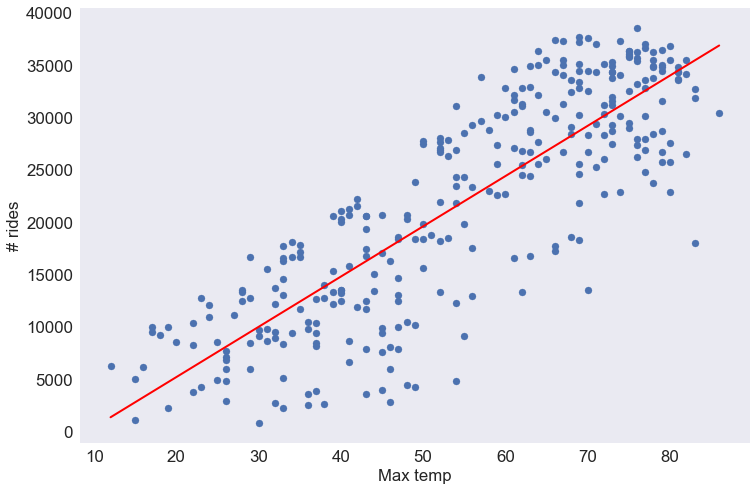

In [31]:
# plot the regression line over the data
X_new = pd.DataFrame({'mean_temp': [comb.mean_temp.min(), comb.mean_temp.max()]})
X_new.head()
preds = lm.predict(X_new)
#preds

plt.figure(figsize=(12,8))
plt.scatter(comb.mean_temp,comb.num_rides)
plt.grid();
plt.xlabel('Max temp')
plt.ylabel('# rides')

plt.plot(X_new,preds,c='red',linewidth=2)

The R^2 value is 0.62, which means that 62% of the variance in num_rides can be explained by the mean temperature.

## Fit linear regression w/ sklearn

In [39]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
X = comb.mean_temp.values.reshape(-1,1)
Y = comb.num_rides.values.reshape(-1,1)
reg.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

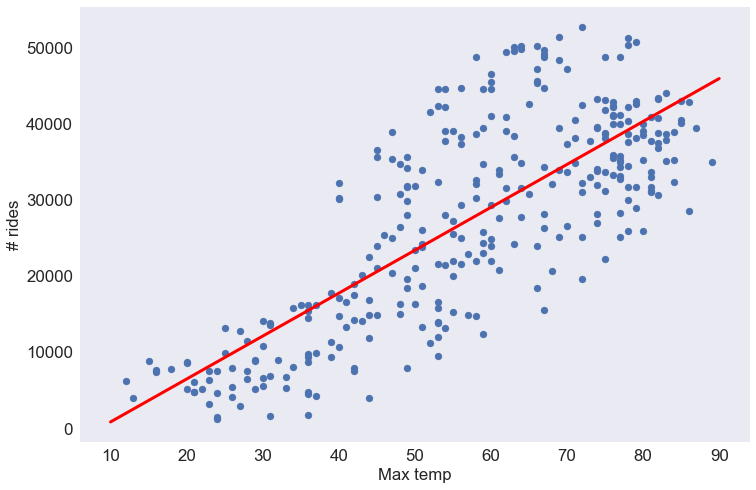

In [40]:
plt.figure(figsize=(12,8))
plt.scatter(comb.mean_temp,comb.num_rides)
plt.grid();
plt.xlabel('Max temp')
plt.ylabel('# rides')
pred_X = np.array([10,90]).reshape(-1,1)
plt.plot(pred_X,reg.predict(pred_X),c='red')

In [41]:
reg.score(X,Y)

0.6052741648450809

## See if other years hold similar patterns

In [78]:
year = 2013
rides = pd.read_sql_query("SELECT yday,count(*) as num_rides FROM rides WHERE year=? GROUP BY yday",con1,params=[year])
rides.head()

wea = pd.read_sql_query("SELECT * FROM temps WHERE year=?",con2,params=[year])
wea['date'] = pd.to_datetime(wea.date)
wea.loc[wea.precip_In=='T'] = 0
wea.loc[:,'precip_In'] = wea.astype({'precip_In':'float64'})
wea.set_index('date',inplace=True)
wea.head()
comb = pd.merge(rides,wea,on='yday')
comb.head()

,yday,num_rides,st_code,max_temp,min_temp,mean_temp,year,month,precip_In,cloud_cover,max_gust_mph,events
0,182,16650,KLGA,78,73,76,2013,7,0.73,8,26,Fog-Rain-Thunderstorm
1,183,22745,KLGA,83,73,78,2013,7,0.06,7,23,Rain-Thunderstorm
2,184,21864,KLGA,85,74,80,2013,7,0.96,7,23,Fog-Rain-Thunderstorm
3,185,22326,KLGA,91,76,84,2013,7,0.00,4,24,None
4,186,21842,KLGA,93,77,85,2013,7,0.00,1,23,None


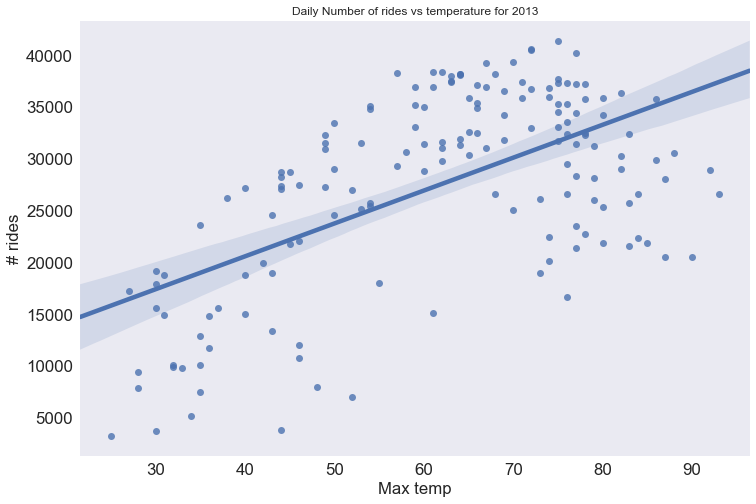

In [80]:
plt.figure(figsize=(12,8))
sns.regplot(comb.mean_temp,comb.num_rides)
plt.grid();
plt.xlabel('Max temp')
plt.ylabel('# rides')
plt.title('Daily Number of rides vs temperature for ' + str(year) );
#plt.savefig('figures/rides_vs_temp_2015.pdf')

In [81]:
lm = smf.ols(formula='num_rides ~mean_temp', data=comb).fit()
lm.rsquared

0.34461690114291887

### Precipitation
- N rides is negatively correlated w/ precipiation
- A lot of days w/ little or no precip

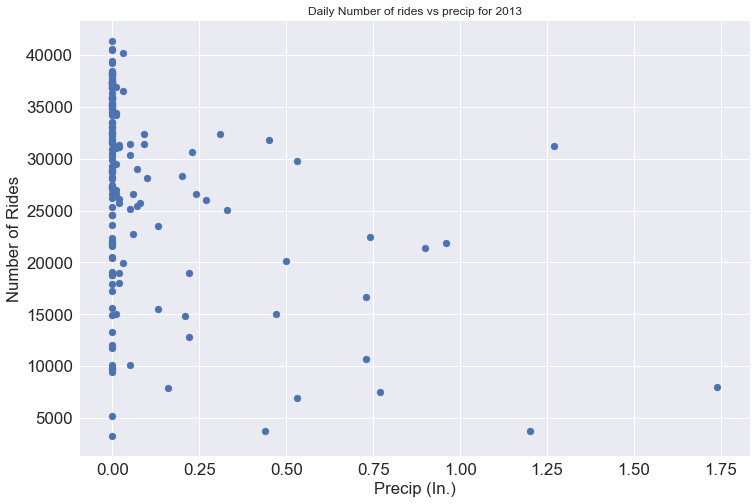

In [82]:
plt.figure(figsize=(12,8))
plt.scatter(comb.precip_In, comb.num_rides)
#sns.regplot(comb.precip_In, comb.num_rides)
plt.xlabel('Precip (In.)')
plt.ylabel('Number of Rides')
plt.title('Daily Number of rides vs precip for ' + str(year) );

### Maximum Wind Gust
- N rides is negatively correlated w/ wind

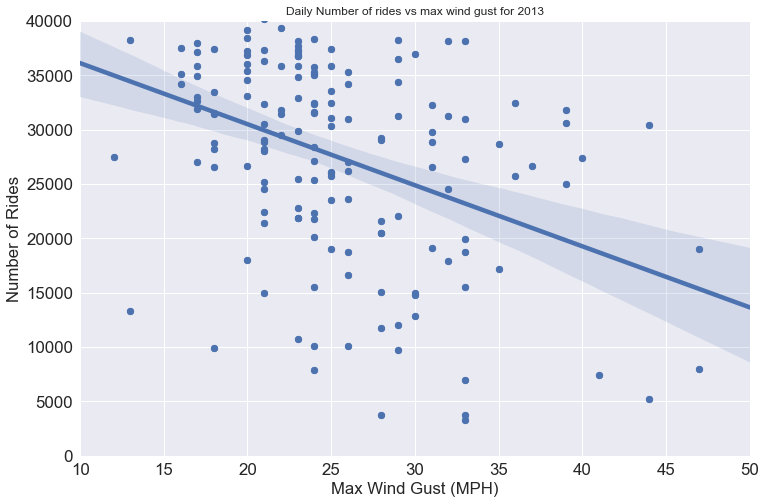

In [83]:
plt.figure(figsize=(12,8))
plt.scatter(comb.max_gust_mph, comb.num_rides)
sns.regplot(comb.max_gust_mph, comb.num_rides)
#sns.jointplot(comb.max_gust_mph, comb.num_rides)
plt.xlabel('Max Wind Gust (MPH)')
plt.ylabel('Number of Rides')
plt.xlim(10,50)
plt.ylim(0,40000)
plt.title('Daily Number of rides vs max wind gust for ' + str(year) );

## Do for all data (instead of 1 year)

In [32]:

rides = pd.read_sql_query("SELECT year,month,day,count(*) as num_rides FROM rides GROUP BY year,month,day ",con1)
rides['date'] = pd.to_datetime(rides[['year', 'month', 'day']])
rides.head()

wea = pd.read_sql_query("SELECT * FROM temps ",con2)
wea['date'] = pd.to_datetime(wea.date)
wea.loc[wea.precip_In=='T'] = 0
wea.loc[:,'precip_In'] = wea.astype({'precip_In':'float64'})
#wea.set_index('date',inplace=True)
wea.head()
#comb = pd.merge(rides,wea,on='yday')
#comb.head()

,date,st_code,max_temp,min_temp,mean_temp,year,yday,month,precip_In,cloud_cover,max_gust_mph,events
0,1970-01-01,0,0,0,0,0,0,0,0.0,0,0.0,0
1,2013-01-02,KLGA,34,23,29,2013,2,1,0.0,7,28.0,None
2,2013-01-03,KLGA,34,25,30,2013,3,1,0.0,5,26.0,None
3,2013-01-04,KLGA,39,33,36,2013,4,1,0.0,3,31.0,None
4,2013-01-05,KLGA,43,34,39,2013,5,1,0.0,3,33.0,None


In [136]:
rides.head()

,year,month,day,num_rides,date
0,2013,7,1,16650,2013-07-01
1,2013,7,2,22745,2013-07-02
2,2013,7,3,21864,2013-07-03
3,2013,7,4,22326,2013-07-04
4,2013,7,5,21842,2013-07-05


In [33]:
comb = pd.merge(rides,wea,on='date')
comb.head()

,year_x,month_x,day,num_rides,date,st_code,max_temp,min_temp,mean_temp,year_y,yday,month_y,precip_In,cloud_cover,max_gust_mph,events
0,2013,7,1,16650,2013-07-01,KLGA,78,73,76,2013,182,7,0.73,8,26.0,Fog-Rain-Thunderstorm
1,2013,7,2,22745,2013-07-02,KLGA,83,73,78,2013,183,7,0.06,7,23.0,Rain-Thunderstorm
2,2013,7,3,21864,2013-07-03,KLGA,85,74,80,2013,184,7,0.96,7,23.0,Fog-Rain-Thunderstorm
3,2013,7,4,22326,2013-07-04,KLGA,91,76,84,2013,185,7,0.00,4,24.0,None
4,2013,7,5,21842,2013-07-05,KLGA,93,77,85,2013,186,7,0.00,1,23.0,None


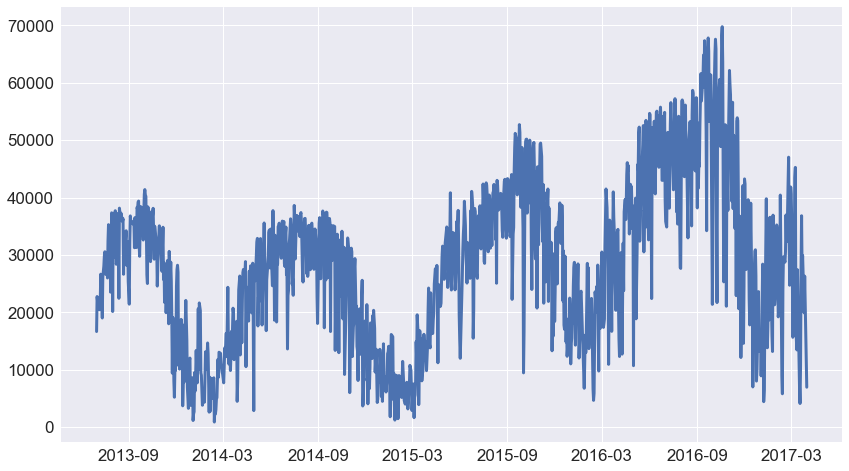

In [34]:
plt.figure(figsize=(14,8))
plt.plot(comb.date,comb.num_rides)

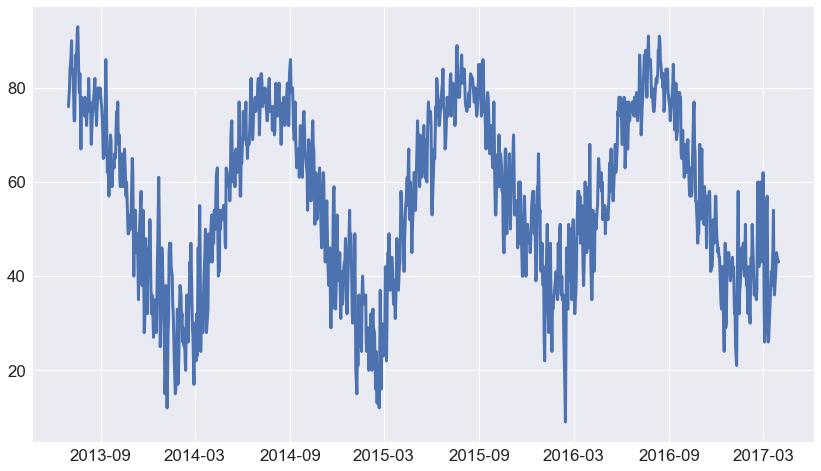

In [35]:
plt.figure(figsize=(14,8))
plt.plot(comb.date,comb.mean_temp)

In [39]:
import statsmodels.formula.api as smf
# create a fitted model in one line
lm = smf.ols(formula='num_rides ~mean_temp', data=comb).fit()
# print the coefficients
lm.params

Intercept   -1537.727787
mean_temp     533.128815
dtype: float64

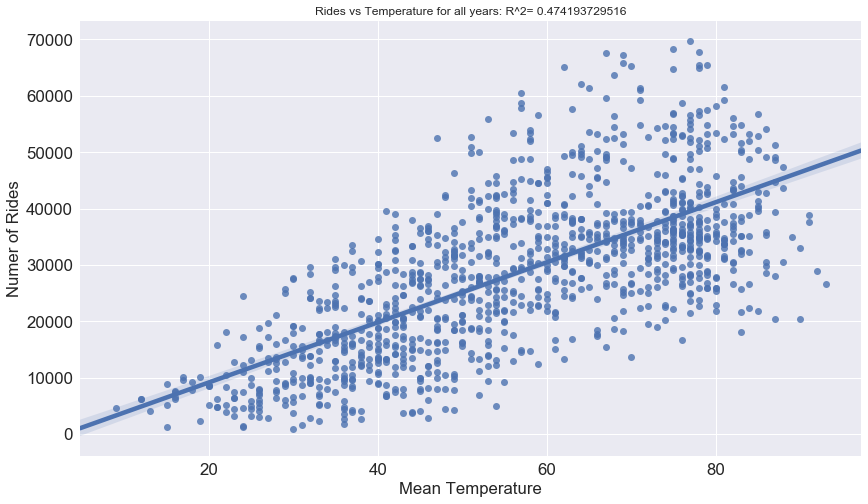

In [40]:
plt.figure(figsize=(14,8))
#plt.scatter(comb.mean_temp, comb.num_rides)
sns.regplot(comb.mean_temp, comb.num_rides)
plt.xlabel('Mean Temperature')
plt.ylabel('Numer of Rides')
plt.title('Rides vs Temperature for all years: R^2= ' + str(lm.rsquared))
plt.savefig('figures/rides_vs_temp_all.pdf')

In [42]:
lm = smf.ols(formula='num_rides ~max_gust_mph', data=comb).fit()
# print the coefficients
lm.params

Intercept       41055.462714
max_gust_mph     -459.601027
dtype: float64

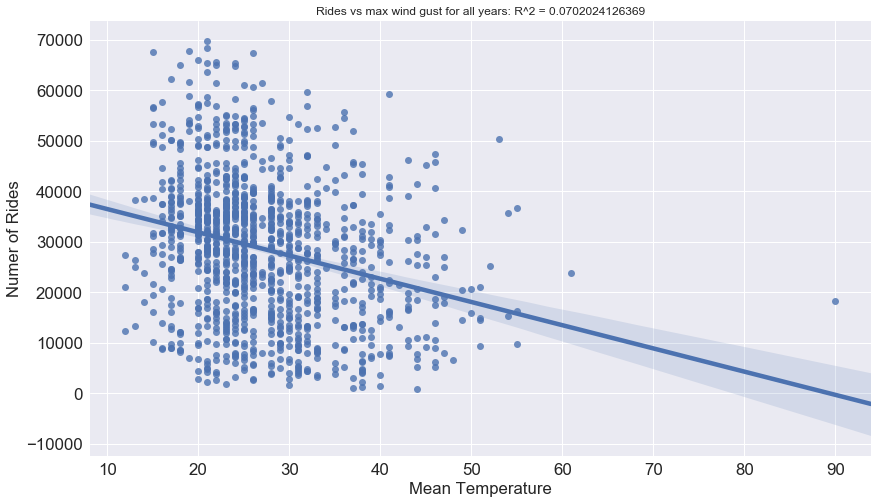

In [44]:
plt.figure(figsize=(14,8))
#plt.scatter(comb.mean_temp, comb.num_rides)
sns.regplot(comb.max_gust_mph, comb.num_rides)
plt.xlabel('Mean Temperature')
plt.ylabel('Numer of Rides')
plt.title('Rides vs max wind gust for all years: R^2 = ' + str(lm.rsquared))
plt.savefig('figures/rides_vs_wind_all.pdf')

In [45]:
lm = smf.ols(formula='num_rides ~precip_In', data=comb).fit()
# print the coefficients
lm.params

Intercept    29945.302860
precip_In   -10770.120462
dtype: float64

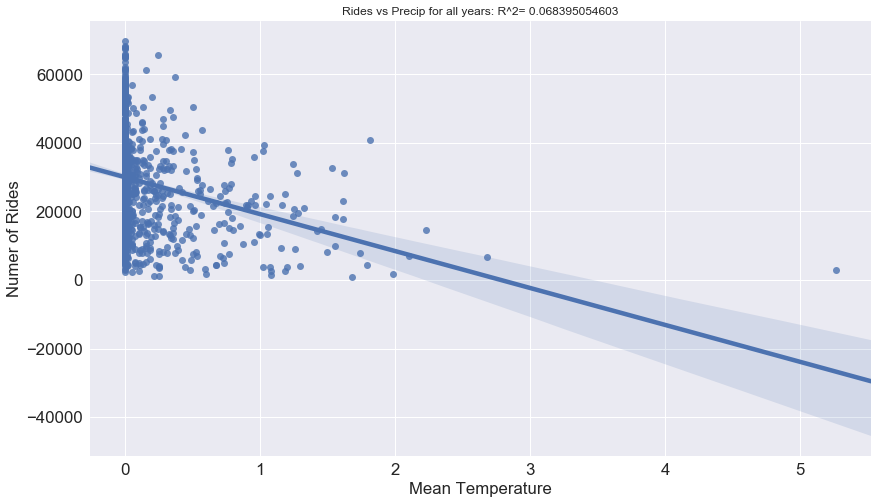

In [46]:
plt.figure(figsize=(14,8))
#plt.scatter(comb.mean_temp, comb.num_rides)
sns.regplot(comb.precip_In, comb.num_rides)
plt.xlabel('Mean Temperature')
plt.ylabel('Numer of Rides')
plt.title('Rides vs Precip for all years: R^2= ' + str(lm.rsquared))
plt.savefig('figures/rides_vs_precip_all.pdf')

### Try regression model w/ just temp,precip,wind

In [47]:
lm = smf.ols(formula='num_rides ~ mean_temp + precip_In + max_gust_mph', data=comb).fit()
# print the coefficients
lm.params

Intercept        2423.856393
mean_temp         521.278957
precip_In      -10111.135421
max_gust_mph      -75.365863
dtype: float64

In [50]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              num_rides   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     461.7
Date:                Thu, 20 Jul 2017   Prob (F-statistic):          8.07e-198
Time:                        16:04:27   Log-Likelihood:                -12402.
No. Observations:                1173   AIC:                         2.481e+04
Df Residuals:                    1169   BIC:                         2.483e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     2423.8564   1509.020      1.606   

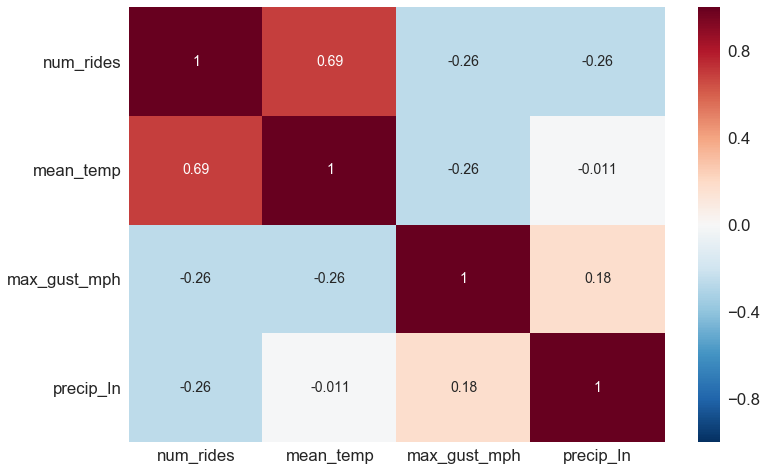

In [66]:
corr = comb[['num_rides','mean_temp','max_gust_mph','precip_In']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True)

plt.savefig('figures/rides_weather_corrplot.pdf')